In [1]:
import numpy as np
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

np.random.seed(0)
torch.manual_seed(0)

1.24.3
2.0.0+cu117
1.11


In [2]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y
        
        
class Line_sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, slope, amplitude, phase, xmin, xmax):
        self.slope = slope
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.cos(self.phase + x) + self.slope * x

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y

In [3]:
class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, x_min, x_max, args, family="sine"):
        self.args = args
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        if(self.family=="sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        elif(self.family=="line_sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            slope = np.random.uniform(self.args["slope_min"], self.args["slope_max"])
            return Line_sine_Task(slope, amplitude, phase, self.x_min, self.x_max)
        else:
            return None

In [4]:
n_shot_train = 5
n_shot_test = 5
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
criterion = nn.MSELoss()

family = "line_sine"

args_line_sine = {"amplitude_min":0.1, "amplitude_max":5.0, 
        "phase_min":0.0, "phase_max":np.pi,
        "slope_min":0.0, "slope_max":3.0}

tasks = Task_Distribution(x_min=train_range[0], x_max=train_range[1], 
                      args=args_line_sine, family=family)


## Defining model

In [5]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        #self.layer3 = nn.Linear(40,40)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = self.layer2(out)
        #out = self.layer3(out)
        return out

In [6]:
class gp_kernel(gpytorch.kernels.Kernel):
    def __init__(self, net, **kwargs):
        super(gp_kernel, self).__init__(**kwargs)
        self.net = net
        
        #self.kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        #self.kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        
        self.kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        
        #self.kernel = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, ard_num_dims=40)
        #train_x, train_y = tasks.sample_task().sample_data(n_shot_train, noise=.1)
        #self.kernel.initialize_from_data(train_x, train_y)

    def forward(self, x1, x2, diag=False, **params):
        phi1 = self.net(x1)
        phi2 = self.net(x2) if x1 is not x2 else phi1
        result = self.kernel(phi1, phi2)
        if diag:
            return result.diag()
        return result

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, net, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gp_kernel(net)
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
net       = Feature()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])
gp = ExactGPModel(dummy_inputs, dummy_labels, net, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3}])

## Training

In [9]:
import time

likelihood.train()
gp.train()
net.train()

tot_iterations=50000

t = time.time_ns()

for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.1)
    # z = net(inputs)
    with gpytorch.settings.cholesky_jitter(float_value=1e-3, double_value=1e-4, half_value=None):
        gp.set_train_data(inputs=inputs, targets=labels)  
        predictions = gp(inputs)
        loss = -mll(predictions, gp.train_targets)
        loss.backward()
        optimizer.step()
        mse = criterion(predictions.mean, labels)
    #---- print some stuff ----
    #print(epoch)
    if(epoch%1000==0):
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))
print(f"Total time : {(time.time_ns()-t)/1e9} s")

tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010],
       grad_fn=<AsStridedBackward0>)
[0] - Loss: 3.020  MSE: 20.824  lengthscale: 0.000   noise: 0.694
tensor([0.0097, 0.0097, 0.0097, 0.0097, 0.0097], grad_fn=<AsStridedBackward0>)
[1000] - Loss: 1.954  MSE: 18.763  lengthscale: 0.000   noise: 0.724
tensor([0.0183, 0.0183, 0.0183, 0.0183, 0.0183], grad_fn=<AsStridedBackward0>)
[2000] - Loss: 2.101  MSE: 20.857  lengthscale: 0.000   noise: 0.645
tensor([0.0319, 0.0319, 0.0319, 0.0319, 0.0319], grad_fn=<AsStridedBackward0>)
[3000] - Loss: 1.757  MSE: 3.279  lengthscale: 0.000   noise: 0.489
tensor([0.0111, 0.0111, 0.0111, 0.0111, 0.0111], grad_fn=<AsStridedBackward0>)
[4000] - Loss: 2.124  MSE: 27.639  lengthscale: 0.000   noise: 0.329
tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250], grad_fn=<AsStridedBackward0>)
[5000] - Loss: 1.680  MSE: 52.767  lengthscale: 0.000   noise: 0.213
tensor([0.0155, 0.0155, 0.0155, 0.0155, 0.0155], grad_fn=<AsStridedBackward0>)
[6000] - Loss: 1.542  MSE

## Test phase on a new sine

In [10]:
family = "line_sine"

args_line_sine = {"amplitude_min":3.0, "amplitude_max":5.0, 
        "phase_min":0.0, "phase_max":np.pi,
        "slope_min":1.0, "slope_max":2.0}

tasks_test = Task_Distribution(x_min=train_range[0], x_max=train_range[1], 
                      args=args_line_sine, family=family)

In [11]:
print("Test, please wait...")

likelihood.eval()    
net.eval()
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Trainable parameters : {trainable_params}")
not_trainable_params = sum(p.numel() for p in net.parameters() if not p.requires_grad)
print(f"Non Trainable parameters : {not_trainable_params}")

tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    
    indices = np.arange(sample_size)
    support_indices_choice = np.arange(sample_size//2)  # Indices where the support data can be
    
    np.random.shuffle(support_indices_choice)
    support_indices = np.sort(support_indices_choice[0:n_shot_test])

    query_indices = np.sort(np.setdiff1d(indices, support_indices))
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    #z_support = net(x_support).detach()
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support, strict=False)  
    gp.eval()

    #Evaluation on query set
    #z_query = net(x_query).detach()
    mean = likelihood(gp(x_query)).mean

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
Trainable parameters : 1720
Non Trainable parameters : 0
-------------------
Average MSE: 0.25235946716554464 +- 1.106670236032014
-------------------


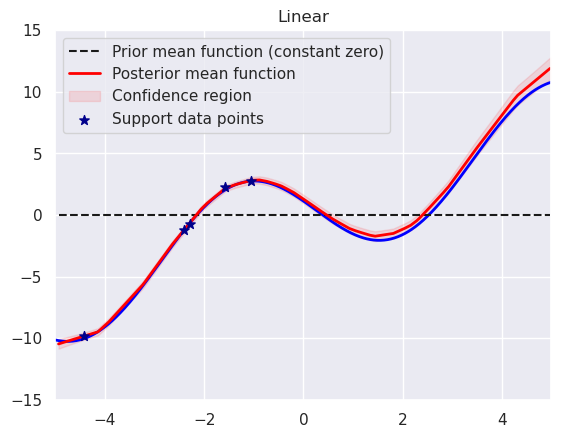

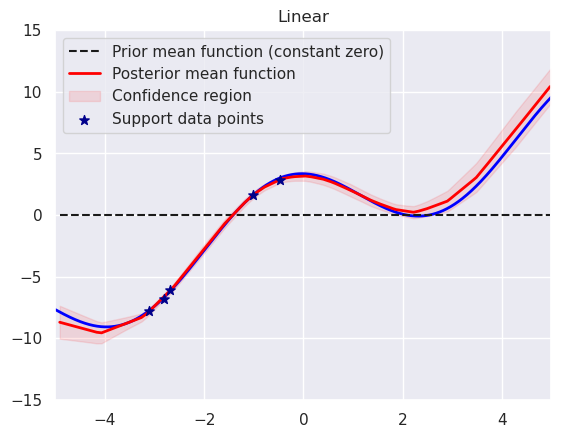

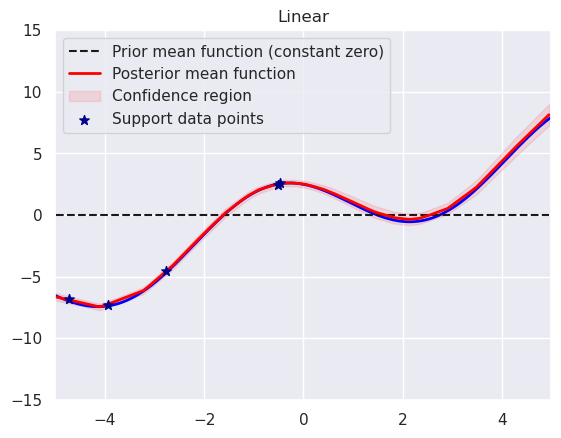

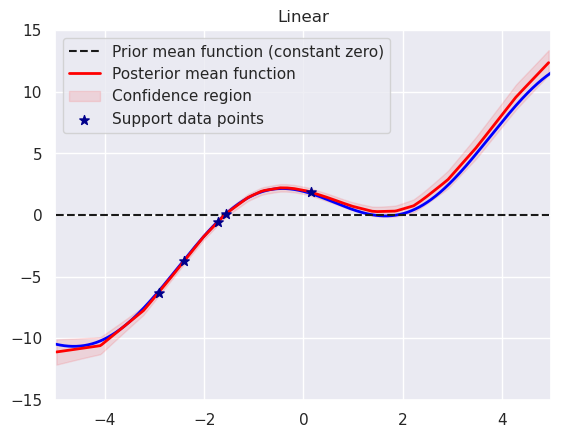

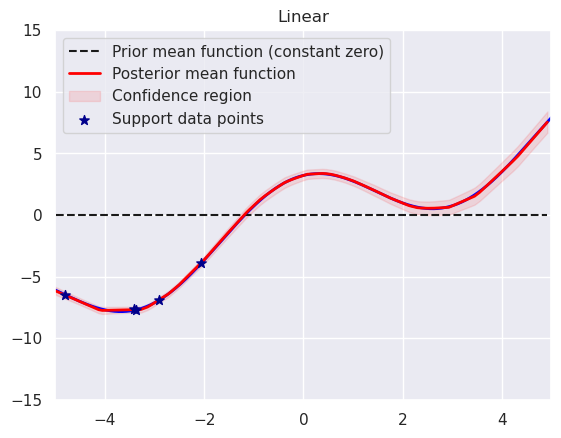

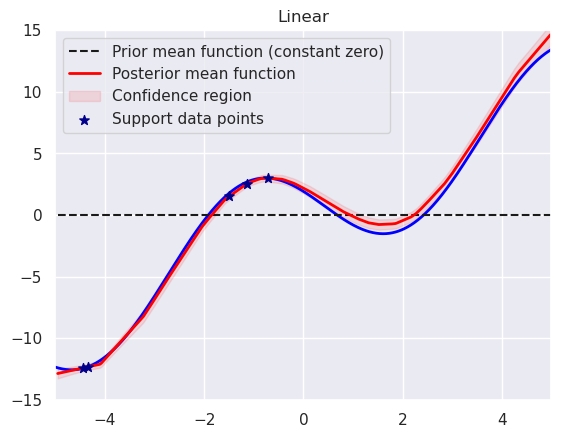

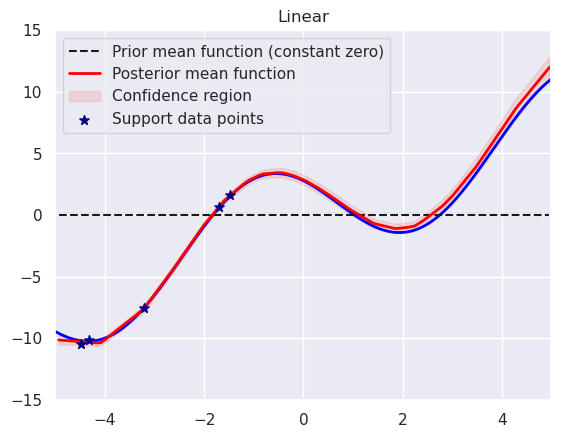

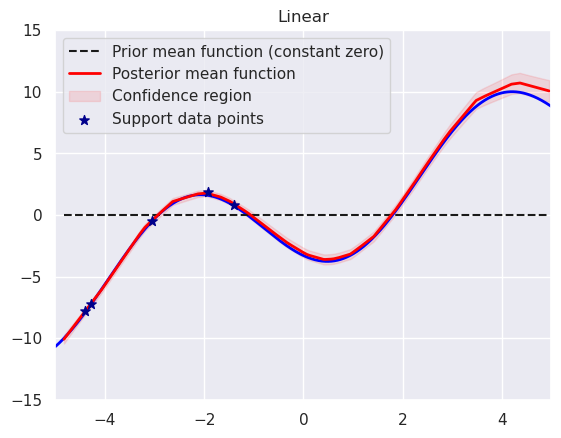

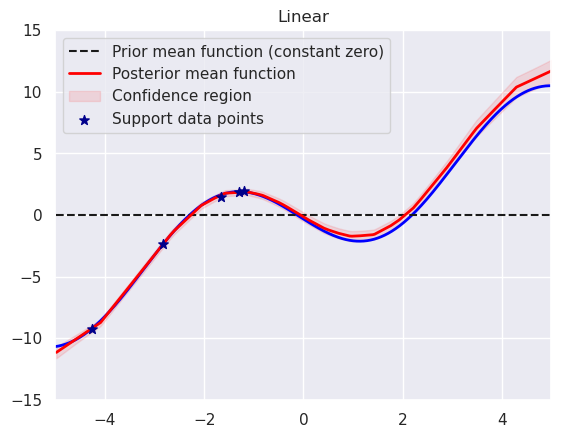

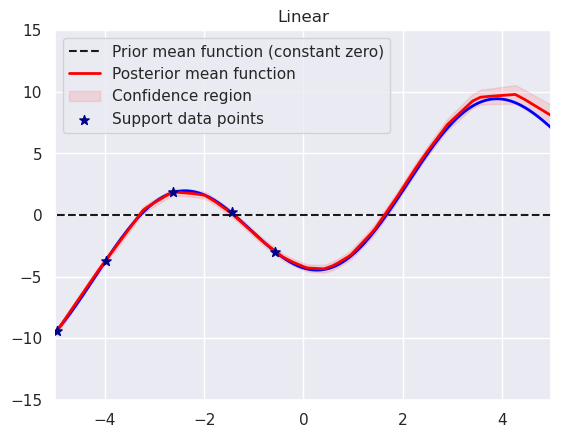

In [12]:
for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    support_indices_choice = np.arange(sample_size//2)  # Indices where the support data can be
    
    np.random.shuffle(support_indices_choice)
    support_indices = np.sort(support_indices_choice[0:n_shot_test])
    #print(support_indices)

    query_indices = np.sort(np.setdiff1d(indices, support_indices))
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]
    
    #z_support = net(x_support).detach()
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support, strict=False)  
    gp.eval()
            
    #Evaluation on all data
    #z_all = net(x_all).detach()
    mean = likelihood(gp(x_all)).mean
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean

    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)
    
    ax.plot(np.squeeze(x_all), np.zeros(sample_size), 'k--', label="Prior mean function (constant zero)")

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0, label="Posterior mean function")
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red', label="Confidence region")
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10, label="Support data points")
    ax.set_title("Linear")
    ax.legend()
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-15.0, 15.0)
    plt.xlim(test_range[0], test_range[1])
    plt.savefig('plot_DKT_linear_' + str(i) + '.png', dpi=300)